# <img src="https://upload.wikimedia.org/wikipedia/commons/6/60/NISAR_artist_concept.jpg" width=400 align="left"/><br><br><br><br>



<img src="https://upload.wikimedia.org/wikipedia/commons/9/9b/NISAR_Mission_Logo.png" width=400 align="left"/><br><br><br><br><br>





# NASA ISRO Synthetic Aperture Radar Mission
## Combined Algorithm Theoretical Basis Document and Jupyter Notebook for <br> *Active Crop Area*

Authors: Shannon Rose, Tracy Whelen, Simon Kraatz, Paul Siqueira <br>
Microwave Remote Sensing Laboratory <br>
University of Massachusetts -- Amherst <br>
Date: 2022-02-14 <br>
[go to TOC](#TOC)

### Summary
This notebook describes the ATBD for generating an agricultural crop area product from NISAR time series data stacks. The algorithm is designed to meet the Level 2 Science requirements for detecting active crop area. This notebook constitutes a combination of formulating the theoretical basis for the NISAR active crop area algorithm that is based on the coefficient of variation and an implementation of the algorithm in executable python code. A test data set accompanies the notebook that can be downloaded at the same time as this notebook.  Should the reader have difficult accessing those resources, they are referred to [here](https://umass-my.sharepoint.com/:f:/g/personal/siqueira_umass_edu/EgRZPHq2VqZJtuWi1MvrJscByMsoVe9z8ESfkg8DdMnX-Q?e=K1wS3L).  This is a link to a OneDrive account at the University of Massachusetts.  The reader can download the *Crop_Area_Notebook.tgz*, which contains this notebook and the necessary files to run the code.

This particular notebook contains two parts that are combined into one notebook.  These are
<ol>
    <li>The Coefficient of Variation (CV) Python code, and</li>
    <li>The USDA Cropland Data Layer (CDL)</li>
</ol>
Although not required to implement the NISAR Active Crop Area algorithm, the CDL is provided here to give an example how external data about the location of active crops can be used to optimally determine the threshold that can be applied to the CV for determining active crop area, and also used as a means for evaluating the algorithm.  For regions outside of the US (for example) where the CDL is not available, a similar landcover classification could be used, or one created from available optical data.

The NISAR requirement for Active Crop Area is <br>
> *Requirement (L2-SCI-679):* <br> After the first year of operation, the NISAR Project shall measure crop area at 1-hectare resolution every 3 months with a classification accuracy of 80%.






<a id="TOC"></a>
### Table of Contents
0.  [Getting Started](#SEC_0)
    <br>0.1 [Overveiw of the Coefficient of Variation](#SEC_0.1)
    <br>0.2 [Data Flow Diagram](#SEC_0.2)
    <br>0.3 [Import Python Modules (code)](#SEC_0.3)
    <br>0.4 [Set the Input Parameters (code)](#SEC_0.4)
    <br>0.5 [Set the Output Parameters (code)](#SEC_0.5)
1. [Get Data](#SEC_1)
    <br>1.1  [Pre-Launch: Get GCOV data from S3 Buckets](#SEC_1.1)
    <br>1.2  [Post-Launch: Query ASF](#SEC_1.2)
    <br>1.3  [Get Geocoding Information from First/Reference Images](#SEC_1.3)
    <br>1.4  [Select Images to Include in Time-Series Stack](#SEC_1.4)
2. [CDL Preparation](#SEC_2)
    <br>2.1  [Download the CDL](#SEC_2.1)
    <br>2.2  [Sample image of the Cropland Data Layer](#SEC_2.2)
    <br>2.3  [A simple Crop-/Non-Crop mask](#SEC_2.3)
    <br>2.4  [Identifying Crop pixels in the CDL](#SEC_2.4)
    <br>2.5  [Image of the Crop/Non-Crop classification based on the CDL](#SEC_2.5)
    <br>2.6  [A statistical summary of the number of Crop and Non-Crop pixels from the CDL](#SEC_2.6)
3.  [Time-Series analysis of SAR images](#SEC_3)
    <br>3.1  [Read in Imagery](#SEC_3.1)
    <br>3.2  [Sample SAR images](#SEC_3.2)
    <br>3.3  [Calculating the CV on the Timeseries Stack](#SEC_3.3)
4.  [Generation of the Receiver Operating Characteristic](#SEC_4)
    <br>4.1  [Applying thrsholds to determine the ROC](#SEC_4.1)
    <br>4.2  [Apply the watermask to each tested point](#SEC_4.2)
    <br>4.3  [Create a binary crop/non-crop classification at each tested threshold](#SEC_4.3)
    <br>4.4  [Determine false alarm and true positive rates](#SEC_4.4)
    <br>4.5  [Calculate sensitivity and specifity](#SEC_4.5)
    <br>4.6  [Calculate the ROC Curve](#SEC_4.6)
    <br>4.7  [Plot the ROC Curve](#SEC_4.7)
5.  [Calculate optimal threshold and other performance metrics](#SEC_5)
    <br>5.1  [Using Youden's Index to Find the Ideal Classification Threshold](#SEC_5.1)
    <br>5.2  [Display Youden's index](#SEC_5.2)
    <br>5.3  [Find the AUC](#SEC_5.3)
    <br>5.4  [Getting Accuracy Statictics for the Youden's Index Optimal Threshold](#SEC_5.4)
    <br>5.5  [Export Accuracy Results](#SEC_5.5)
    <br>5.6  [Export Classified Image](#SEC_5.6)

6. [References](#SEC_6)

[back to TOP](#TOP)

<a id="SEC_0"></a>
<a id="SEC_0.1"></a>
# 0  &emsp; Getting Started
## 0.1 &emsp; Overview of the Coefficient of Variation
Python code to implement coefficient of variation (CV) for crop/non-crop classification using a Receiver Operating Characteristic (ROC) curve for a time-series of SAR images. The notebook statistically calculates the CV for a stack of time-series imagery. The CV output is then used to generate a ROC curve by using the USDA Cropland Data Layer (CDL) as ground truth. Pixels classified by the CDL as "Water" are masked and not used in classification because, water has a high variation measurement not comparable to the CV values of other non-cropland land covers and is often missclassified because of this. The statistic Youden's Index is calculated to detemine the ideal threshold on the curve to use for best classification results. The accuracy of the classification compared to the CDL as ground truth are calculated for the CV crop/non-crop classification. The classified image is exported as a Geotiff. A CSV file is exported containing accuracy statistics for the classification.

Coefficient of Variation is calculated by: Standard Deviation/Mean

Datasets needed:

    Timeseries of SAR imagery
    
    CDL available at https://nassgeodata.gmu.edu/CropScape/



<a id="SEC_0.2"></a>
## 0.2  &emsp; Data Flow Diagram

![data_flow_diagram](CV_ROC_Data_Flow.png)


<a id="SEC_0.4"></a>
## 0.3 &emsp; Import Python Modules

In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from osgeo import gdal, osr, ogr
import subprocess
import os
import time
import scipy
import pandas as pd
import sys
from pandas import DataFrame
from IPython.display import Image
import sklearn  # imported from scikit-learn
from sklearn import metrics
from matplotlib.pyplot import figure
from matplotlib.colors import ListedColormap
from ipywidgets import interactive
from rasterio.plot import show_hist
import datetime

from pathlib import Path
import boto3
import rasterio
import zipfile
import h5py
from pyproj import CRS


<a id="SEC_0.5"></a>
## 0.4 &emsp; Set the Input Parameters

Note: 
    1. For use in this notebook all raster datasets must be set to the same grid with pixels aligned
    2. The only data that can be in the set "inputs" is the timeseries SAR imagery

In [2]:
aoi = 'Little_River_GA'

In [3]:
main_dir = Path(os.getcwd()) #Path('/scratch/alex_eco_test')
ancillary_dir = Path(os.getcwd()).resolve().parents[0] / 'ancillary_data'


In [4]:
aoi_dir = main_dir / aoi / 'crops'
ALOS2_dir = aoi_dir / 'ALOS2'
GCOV_dir = aoi_dir / 'GCOV'
TMP_dir = aoi_dir / 'TMP'

Path(aoi_dir).mkdir(parents=True, exist_ok=True)
Path(ALOS2_dir).mkdir(parents=True, exist_ok=True)
Path(GCOV_dir).mkdir(parents=True, exist_ok=True)
Path(TMP_dir).mkdir(parents=True, exist_ok=True)

bucket_name = "nisar-st-data-ondemand" #fill in S3_bucket name
s3_path = 'ALOS2_processed/%s/' %(aoi)


<a id="SEC_1"></a>
# 1 &emsp; Get Data


<a id="SEC_1.1"></a>
# 1.1  &emsp; Pre-Launch: Get GCOV Data from S3 Buckets


In [5]:
all_SAR_data = sorted(glob.glob(str(GCOV_dir / '*_gcov_*.h5')))

if len(all_SAR_data) == 0:
    s3 = boto3.client("s3")
    response = s3.list_objects_v2(
                Bucket=bucket_name,
                Prefix = s3_path)

    contents = response.get('Contents')
    existing_ALOS2_zipfiles = [contents[i].get('Key').split('/')[-1] for i in range(len(contents)) if ('.h5' in contents[i].get('Key')) &('_gcov_' in contents[i].get('Key'))]
    existing_ALOS2_zippaths = [contents[i].get('Key') for i in range(len(contents)) if ('.h5' in contents[i].get('Key')) &('_gcov_' in contents[i].get('Key'))]
    paths = np.unique([i.split('/')[2] for i in existing_ALOS2_zippaths])
    frames = np.unique([i.split('/')[3] for i in existing_ALOS2_zippaths])
    beams = np.unique([i.split('/')[4] for i in existing_ALOS2_zippaths])

    path = int(input('Which path to process? %s' %(paths)))
    frame = int(input('Which frame to process? %s' %(frames)))
    if beams[0] != 'GCOV':
        beam = input('Which Beam to process? %s' %(beams))
        s3_path = 'ALOS2_processed/%s/%s/%s/%s' %(aoi,path,frame,beam)
    else:
        s3_path = 'ALOS2_processed/%s/%s/%s' %(aoi,path,frame)

    response = s3.list_objects_v2(
                Bucket=bucket_name,
                Prefix = s3_path)

    contents = response.get('Contents')
    existing_ALOS2_zipfiles = [contents[i].get('Key').split('/')[-1] for i in range(len(contents)) if ('.h5' in contents[i].get('Key')) &('_gcov_' in contents[i].get('Key'))]
    existing_ALOS2_zippaths = [contents[i].get('Key') for i in range(len(contents)) if ('.h5' in contents[i].get('Key')) &('_gcov_' in contents[i].get('Key'))]

    try:
        shutil.rmtree(GCOV_dir)
        Path(GCOV_dir).mkdir(parents=True, exist_ok=True)
    except:''
    for filename in existing_ALOS2_zipfiles:
        i = existing_ALOS2_zipfiles.index(filename)
        s3_path_new = existing_ALOS2_zippaths[i]
        s3.download_file(bucket_name, s3_path_new , GCOV_dir/filename)


    

<a id="SEC_1.2"></a>
# 1.2  &emsp; Post-Launch: Query ASF for GCOV Data 


In [6]:
# search_by_wkt = False

# opts = {
#         'platform':asf.PLATFORM.NISAR,
#         # 'processingLevel': 'L2',
#         # 'start':'December 1, 2024',
#         # 'end':'May 1, 2025',
#         # 'beamMode': ['FBS','FBD','PLR']
#         # 'maxResults':5,
#         # 'flightDirection':asf.FLIGHT_DIRECTION.ASCENDING,
#         }

# if search_by_wkt: ## Requires a geojson within the AOI directory. 
#     gdf = json.loads(open('%s.geojson' %(aoi_dir/aoi)).read())
#     wkt = str('Polygon((')
#     points = len(gdf['features'][0]['geometry']['coordinates'][0][0])
#     for i in range(points):
#         wkt = wkt + str(gdf['features'][0]['geometry']['coordinates'][0][0][i][0]) + ' ' + str(gdf['features'][0]['geometry']['coordinates'][0][0][i][1]) 
#         if i<points-1:
#             wkt = wkt + ','
#     wkt = wkt + '))'
#     results = asf.geo_search(intersectsWith=wkt, **opts)

# else: ## Searches by orbit and frame, if these are known.
#     opts.update({
#                 # 'absoluteOrbit': [25487], ## orbit from talib
#                 # 'asfFrame':1440 ##frame from talib
#                 })
#     results = asf.search(**opts)


# list_of_NISAR_GCOVs = [results.geojson()['features'][x]['properties']['url'] for x in range(len(results.geojson()['features']))]
# print('\n'.join(list_of_NISAR_GCOVs))

# frames = list(np.unique([f.split('-')[0][-4:] for f in list_of_NISAR_GCOVs]))
# # print('\n'.join(frames))



In [7]:
# frame = input('which frame do you want to process? %s' %(frames))
# # list_of_NISAR_GCOVs = [k for k in all_results if frame in k]
# indices = [frames.index(k) for k in frames if frame in k]
# [list_of_NISAR_GCOVs[i] for i in indices]


In [8]:
# NISAR_ids = []
# response = s3.list_objects_v2(
#             Bucket=bucket_name,
#             Prefix = s3_path)
#             # MaxKeys=100)
#             # Delimiter = '/')
# contents = response.get('Contents')
# existing_NISAR_hdf5 = [contents[i].get('Key').split('/')[-1] for i in range(len(contents)) if '.h5' in contents[i].get('Key')]
# existing_NISAR_hdf5paths = [contents[i].get('Key') for i in range(len(contents)) if '.h5' in contents[i].get('Key')]

# for i in indices:
#     filename =  list_of_NISAR_GCOVs[i].split('/')[-1]
#     NISAR_ids.append(filename)
#     print('Requested File: ', filename)
#     if os.path.isdir(GCOV_dir/filename.split('/')[-1][:-4])==True & (filename in existing_NISAR_hdf5)==True:
#         print('NISAR file is stored on S3 and already available locally')
#     elif (os.path.isfile(GCOV_dir/filename)==False) & (filename in existing_NISAR_hdf5):
#         i = existing_NISAR_hdf5.index(filename)
#         s3_path_new = existing_NISAR_hdf5paths[i]
#         print('\tNISAR HDF5 is already available at S3 PATH: ', s3_path_new)
#         print('\tMove NISAR HDF5 from S3 to local')
#         s3.download_file(bucket_name, s3_path_new , GCOV_dir/filename)
        
#     elif (os.path.isfile(GCOV_dir/filename)==False) & (filename not in existing_NISAR_hdf5):
#         print('\tNISAR HDF5 is not available anywhere')
#         print('\tDownloading NISAR HDF5')
#         try:
#             results[i].download(path=GCOV_dir)#, session=session)
#         except:
#             print('Your .netrc file is not configured. We will authenticate a session with your username and password')
#             user = input('What is your earthdata username?')
#             psw = input('What is your earthdata password?')
#             session = asf.ASFSession().auth_with_creds(user, pwd)
#             results[i].download(path=GCOV_dir, session=session)
#         print('\tMoving a copy NISAR HDF5 to S3 bucket')
#         s3.upload_file(Filename= str(GCOV_dir / filename), Bucket=bucket_name, Key='%s%s/%s' %(s3_path,aoi,filename))

#     elif (os.path.isfile(GCOV_dir/filename)==True) & (filename not in existing_ALOS1_zipfiles):
#         print('\tNISAR HDF5 is available locally, but not on S3')
#         print('\tMoving a copy NISAR HDF5 to S3 bucket')
#         s3.upload_file(Filename= str(GCOV_dir / filename), Bucket=bucket_name, Key='%s%s/%s' %(s3_path,aoi,filename))

#     else: 
#         print('\tNISAR HDF5 file exists locally and on S3')
  
    


<a id="SEC_1.3"></a>
# 1.3  &emsp; Get Geocoding Information from First/Reference Images


In [9]:
all_SAR_data = sorted(glob.glob(str(GCOV_dir / '*.h5')))

print('\n'.join([i.split('/')[-1] for i in all_SAR_data]))


0000462472_001001_ALOS2414460620-220125_gcov_32617.h5
0000463996_001001_ALOS2418600620-220222_gcov_32617.h5
0000463999_001001_ALOS2416530620-220208_gcov_32617.h5
0000464630_001001_ALOS2422740620-220322_gcov_32617.h5
0000464635_001001_ALOS2420670620-220308_gcov_32617.h5
0000469345_001001_ALOS2424810620-220405_gcov_32617.h5
0000471233_001001_ALOS2431020620-220517_gcov_32617.h5
0000473052_001001_ALOS2437230620-220628_gcov_32617.h5
0000474588_001001_ALOS2439300620-220712_gcov_32617.h5
0000474967_001001_ALOS2441370620-220726_gcov_32617.h5
0000476738_001001_ALOS2443440620-220809_gcov_32617.h5
0000478836_001001_ALOS2445510620-220823_gcov_32617.h5
0000480756_001001_ALOS2447580620-220906_gcov_32617.h5
0000482968_001001_ALOS2449650620-220920_gcov_32617.h5
0000484610_001001_ALOS2451720620-221004_gcov_32617.h5
0000485981_001001_ALOS2453790620-221018_gcov_32617.h5
0000487640_001001_ALOS2455860620-221101_gcov_32617.h5
0000489256_001001_ALOS2457930620-221115_gcov_32617.h5
0000493225_001001_ALOS246000

In [10]:
ref_image = all_SAR_data[0]
f = h5py.File(ref_image, "r") 
a_group_key = list(f.keys())[0]
ds_x = f[a_group_key]['LSAR']['GCOV']['grids']['frequencyA']['xCoordinates'][()]      # returns as a h5py dataset object
ds_y = f[a_group_key]['LSAR']['GCOV']['grids']['frequencyA']['yCoordinates'][()]      # returns as a h5py dataset object
ds_epsg = f[a_group_key]['LSAR']['GCOV']['grids']['frequencyA']['projection'][()]
cols = ds_x.shape[0]
rows = ds_y.shape[0]
print('X Size: ',cols,' Y Size: ',rows)

yres = abs(ds_y[0] - ds_y[1])
xres = abs(ds_x[0] - ds_x[1])
print('Resolution X:', xres, ' Y:',yres,'m')

# ref_te = ds_x[0],ds_x[-1],ds_y[0],ds_y[-1]
ulx = xres * round((ds_x[0] - ((ds_x[1] - ds_x[0])/2))/xres)
lrx = xres * round(ds_x[-1]/xres)
uly = yres * round((ds_y[0] - ((ds_y[1] - ds_y[0])/2))/yres)
lry = yres * round(ds_y[-1]/yres)
print('Raster bounds: ',ulx,lrx,uly,lry)#min(ds_x),max(ds_x),min(ds_y),max(ds_y))
geotransform = [ulx, xres, 0.0, uly, 0.0, -yres]

spatialref = CRS.from_user_input(ds_epsg).to_wkt()
print(ds_epsg)

X Size:  3097  Y Size:  3794
Resolution X: 20.0  Y: 20.0 m
Raster bounds:  221940.0 283880.0 3541080.0 3465200.0
32617


<a id="SEC_1.4"></a>
# 1.4  &emsp; Select Images to Include in Time-Series Stack


In [11]:
indices = range(0,len(all_SAR_data))
## If you don't want to use all of the images, choose which indices to use now. 
indices = range(0,9)


num=indices[0]
print("Dates of observation (HH and HV):")
date_array = []
SAR_images = []
for ii in range(0,len(indices)):
    datestr = all_SAR_data[ii].split('/')[-1].split('_')[2][-6:]
    year = 2000 + int(datestr[0:2]) #(2000+int(datestr[0][0:2]))
    month = int(datestr[2:4]) #int(datestr[0][2:4])
    day = int(datestr[4:6]) #int(datestr[0][4:6])
    date_obj = datetime.date(year,month,day)
    print(date_obj)
    date_array.append(date_obj)
    SAR_images.append(all_SAR_data[ii])


Dates of observation (HH and HV):
2022-01-25
2022-02-22
2022-02-08
2022-03-22
2022-03-08
2022-04-05
2022-05-17
2022-06-28
2022-07-12


[back to TOP](#TOP)<br>
[back to TOC](#TOC)

<a id="SEC_2"></a>
# 2 &emsp; CDL Preparation

<a id="SEC_2.1"></a>
## 2.1 &emsp; Download the Cropland Data Layer

Having access to the Cropland Data Layer ([CDL](https://nassgeodata.gmu.edu/CropScape/); a landcover classification for the continental US) is not required for the Coefficient of Variation algorithm, it can be used as an input to determine the location of crops versus non-crops, and hence used to determine the best threshold for the NISAR Active Crop Area algorithm.  In locations where the CDL is not available, other products may be available (such as ESA's [GlobCover](http://due.esrin.esa.int/page_globcover.php) and [High Resolution Ground Cover](https://climate.esa.int/en/projects/high-resolution-land-cover/)), or derived independently from available high-resolution optical data.

The data provided as part of this NISAR ATDB Notebook has been extracted from the CDL and provided locally so that the notebook can be self-contained and it is not necessary to download those resources to exercise the NISAR Active Crop Area algorithm.


In [12]:
# read in the CDL colormap (an index of color values) and identify it as a colormap
# CDL = glob.glob(str(aoi_inputs/'CDL*.tif'))[0]

cdl_cmap = np.loadtxt(ancillary_dir / 'cdl_cmap.txt',dtype='float')
cdl_cmap = ListedColormap(cdl_cmap)

cdl_year = 2022
cdl_dir = ancillary_dir / 'cdl'
cdl_full_file = '%s_30m_cdls' %(cdl_year)

if os.path.isfile(cdl_dir/ (cdl_full_file +'.tif'))==False:
    if os.path.isfile(cdl_dir / (cdl_full_file + '.zip'))==False:
        url = 'https://www.nass.usda.gov/Research_and_Science/Cropland/Release/datasets/%s' %(cdl_full_file)
        command = f"wget -P {cdl_dir} -q {'https://www.nass.usda.gov/Research_and_Science/Cropland/Release/datasets/2022_30m_cdls.zip'}"
        output = subprocess.check_output(command, shell=True)
    with zipfile.ZipFile(cdl_dir / (cdl_full_file + '.zip'), 'r') as zip_ref:
        zip_ref.extractall(cdl_dir)
    os.remove(cdl_dir/ (cdl_full_file + '.zip'))
CDL_full = glob.glob(str(cdl_dir / (cdl_full_file + '.tif')))[0]
    

In [13]:
####### OLD GEOTIFF VERSION
# # Select the images for the time series-- all "*.tif" images in set working directory


# with rasterio.open(ref_image) as src:
#     ref_te = src.bounds
#     ref_tr = src.transform[0]
#     epsg = src.crs

# os.system('gdalwarp -overwrite -s_srs epsg:5070 -t_srs %s -tr %s %s -te %s %s %s %s %s %s_cdl.tif' 
#           %(epsg,ref_tr,ref_tr,ref_te.left,ref_te.bottom,ref_te.right,ref_te.top,CDL_full,aoi_inputs/aoi))


## Choose reference image from SAR stack and get geocoding information

In [14]:
ref_image = SAR_images[0]
f = h5py.File(ref_image, "r") 
a_group_key = list(f.keys())[0]
ds_x = f[a_group_key]['LSAR']['GCOV']['grids']['frequencyA']['xCoordinates'][()]      # returns as a h5py dataset object
ds_y = f[a_group_key]['LSAR']['GCOV']['grids']['frequencyA']['yCoordinates'][()]      # returns as a h5py dataset object
ds_epsg = f[a_group_key]['LSAR']['GCOV']['grids']['frequencyA']['projection'][()]
cols = ds_x.shape[0]
rows = ds_y.shape[0]
print('X Size: ',cols,' Y Size: ',rows)

yres = abs(ds_y[0] - ds_y[1])
xres = abs(ds_x[0] - ds_x[1])
print('Resolution X:', xres, ' Y:',yres,'m')

# ref_te = ds_x[0],ds_x[-1],ds_y[0],ds_y[-1]
ulx = xres * round((ds_x[0] - ((ds_x[1] - ds_x[0])/2))/xres)
lrx = xres * round(ds_x[-1]/xres)
uly = yres * round((ds_y[0] - ((ds_y[1] - ds_y[0])/2))/yres)
lry = yres * round(ds_y[-1]/yres)
print('Raster bounds: ',ulx,lrx,uly,lry)#min(ds_x),max(ds_x),min(ds_y),max(ds_y))
geotransform = [ulx, xres, 0.0, uly, 0.0, -yres]

# A geotransform consists in a set of 6 coefficients:
# GT(0) x-coordinate of the upper-left corner of the upper-left pixel.
# GT(1) w-e pixel resolution / pixel width.
# GT(2) row rotation (typically zero).
# GT(3) y-coordinate of the upper-left corner of the upper-left pixel.
# GT(4) column rotation (typically zero).
# GT(5) n-s pixel resolution / pixel height (negative value for a north-up image).

spatialref = CRS.from_user_input(ds_epsg).to_wkt()
print(ds_epsg)

mask = np.where(np.isnan(f[a_group_key]['LSAR']['GCOV']['grids']['frequencyA']['HHHH'][()]),np.nan,1)

X Size:  3097  Y Size:  3794
Resolution X: 20.0  Y: 20.0 m
Raster bounds:  221940.0 283880.0 3541080.0 3465200.0
32617


## Extract/Crop CDL raster to reference image

In [15]:
os.system('gdalwarp -overwrite -s_srs epsg:5070 -t_srs epsg:%s -tr %s %s -te %s %s %s %s %s %s_cdl.tif' 
          %(ds_epsg,abs(xres),abs(yres),ulx,lry,lrx,uly,CDL_full,aoi_dir/aoi))


Copying raster attribute table from /home/jovyan/NISAR_ATBD_crops/ancillary_data/cdl/2022_30m_cdls.tif to new file.
Copying color table from /home/jovyan/NISAR_ATBD_crops/ancillary_data/cdl/2022_30m_cdls.tif to new file.
Creating output file that is 3097P x 3794L.
Processing /home/jovyan/NISAR_ATBD_crops/ancillary_data/cdl/2022_30m_cdls.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


0

/home/jovyan/.local/envs/ecosystems_atbd/lib/python3.11/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


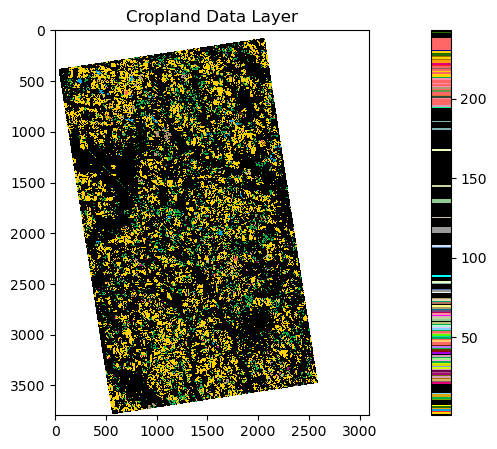

In [16]:
# Open CDL
cdl_raster = gdal.Open(str(aoi_dir / (aoi + '_cdl.tif'))).ReadAsArray()*mask

# Get dimensions of CDL
first_raster_CDL = gdal.Open(str(aoi_dir / (aoi + '_cdl.tif')))
rows1 = first_raster_CDL.RasterYSize
cols1 = first_raster_CDL.RasterXSize

CDL_geotransform = first_raster_CDL.GetGeoTransform()
CDL_xres = CDL_geotransform[1]
CDL_yres = -CDL_geotransform[5]
CDL_xmin = CDL_geotransform[0]
CDL_ymax = CDL_geotransform[3]
CDL_spatialref = first_raster_CDL.GetProjectionRef()

plt.rcParams['figure.figsize'] = (20,5);
plt.imshow(cdl_raster,cmap=cdl_cmap,interpolation='nearest');
plt.colorbar(fraction=0.046*cdl_raster.shape[0]/cdl_raster.shape[1],pad=0.04);
plt.title('Cropland Data Layer');

##The image might look a little busy because of the number of classes in the layer

[back to TOP](#TOP)<br>
[back to TOC](#TOC)

<a id="SEC_2.2"></a>
## 2.2 &emsp; Sample image of the Cropland Data Layer
Creating a mask to not include pixels in the CDL classified as "Water".
Water has a high variation measurement not comparable to the CV values of other non-cropland land covers and is often missclassified because of this.

The numeric classification value of "Water" in the CDL is 111.
The mask sets water (111 values) to 111 and everything else to 0.

Note: Additional masking can be completed outside of this notebook by classifying these areas in the CDL as 111 for use in this         notebook.
   Some pervious factors that were masked during classification to eliminate errors inherently present in the CDL:
       1. Pixels that are not surrounded by their same land cover type 
       2. Classified land areas smaller than two hectares in size

[back to TOP](#TOP)<br>
[back to TOC](#TOC)

<a id="SEC_2.3"></a>
## 2.3 &emsp; A simple Crop/Non-Crop mask
In creating a Crop/Non-Crop mask from the Cropland Data Layer, the first step is to identify all of those pixels that are makred as "water" (index value 111 in the CDL).  The water pixels in the CDL encompass not only water pixels, but often other types of infrastructure (e.g. roads) that has a similar signature in the optical image time-series that is used for generating the CDL.  A water mask for the Coefficient of Variation algorithm is important because water will have a confounding signature in radar similar to that of crops.

The image below shows those pixels of the CDL that are marked as water, with red being everything else.


Number of water pixels: 137955
Number of pixels for classification: 6915810
water pixels are marked as white


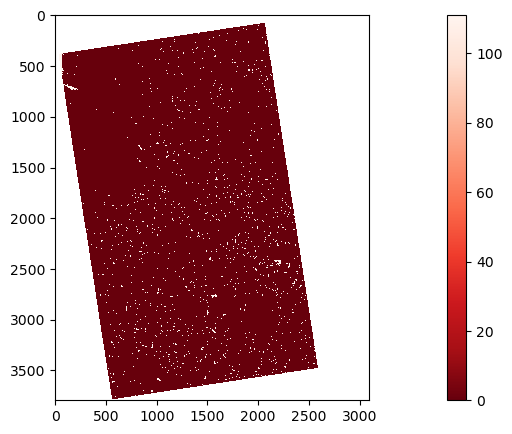

In [17]:
water_number = 111
watermask1 = cdl_raster == water_number
watermask= np.multiply(cdl_raster,watermask1)

# Get the number of pixels masked and not masked 
cdl111 = np.count_nonzero(watermask == water_number) 
print("Number of water pixels:", cdl111)

cdl0 = np.count_nonzero(watermask == 0)
print("Number of pixels for classification:", cdl0)

plt.rcParams['figure.figsize'] = (20,5)
plt.imshow(watermask,interpolation='nearest')
plt.set_cmap('Reds_r')
# For more colormaps, see: https://gallantlab.github.io/colormaps.html
plt.colorbar();
print('water pixels are marked as white')

[back to TOP](#TOP)<br>
[back to TOC](#TOC)

<a id="SEC_2.4"></a>
## 2.4 &emsp; Identifying Crop pixels in the CDL

Creating a binary crop/non-crop classification from the CDL classified classes.

Crop classified to 1

Non-crop classified to 0

This can be customized by study area and what land use types are present there. 
To make a land class classified as non-crop simply place a "#" infront of the line of code for that land cover.

In the code that follows, these are assigned one-by-one according the to various index indicators that are part of the CDL.


In [18]:
CDL_crop = np.copy(cdl_raster)
unique = np.unique(cdl_raster)
uniquecount = len(unique)

# Get Crop names and ids
# Column 0 = Crop ID
# Column 1 = Crop Name
# Column 2 = Classification number (1 = crop 0 = not crop)

crop_ids = pd.read_csv(ancillary_dir / 'crop_ids.csv',header=None)
# Set all crop classification values equal to 1 
for i in crop_ids[0]:
    CDL_crop[np.where(cdl_raster==i)] = crop_ids[crop_ids[0]==i][2]
    


[back to TOP](#TOP)<br>
[back to TOC](#TOC)

<a id="SEC_2.5"></a>
## 2.5 &emsp; Image of the Crop/Non-Crop classification based on the CDL
Below is the resulting clasification image of Crop versus Non-Crop based on the input Cropland Data Layer

Crop pixels marked as white (value of 1.0)


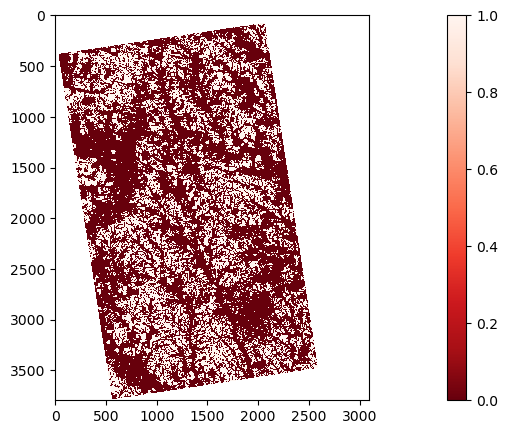

In [19]:
# Set all non-crop values to 0 based on assumming that everything not previously classified as crop is non-crop
CDL_binary = np.copy(CDL_crop)
CDL_binary[np.where(CDL_crop!= 1)]= 0
CDL_binary = CDL_binary*mask
plt.imshow(CDL_binary,interpolation='nearest')
plt.colorbar();
print('Crop pixels marked as white (value of 1.0)')

[back to TOP](#TOP)<br>
[back to TOC](#TOC)

<a id="SEC_2.6"></a>
## 2.6 &emsp; A statistical summary of the number of Crop and Non-Crop pixels from the CDL

Finding the breakdown of crop/non-crop pixels

In [20]:
#getting the number of pixels classified as crop and non-crop including the removal of masked pixels
cropcount = np.count_nonzero(CDL_binary == 1)
print("Number of crop pixels:", cropcount)

noncount = np.count_nonzero(CDL_binary == 0)- cdl111
print("Number of non-crop pixels:",noncount)

#finding the percent of pixels classified as crop and non-crop including the removal of masked pixels
percent_crop_nonmasked_calc = round((cropcount / cdl0)*100, 2)
print ("% Crop: ", percent_crop_nonmasked_calc)

percent_noncrop_nonmasked_calc = round((noncount / cdl0)*100, 2)
print ("% Non-crop: ", percent_noncrop_nonmasked_calc)

Number of crop pixels: 2339547
Number of non-crop pixels: 4576263
% Crop:  33.83
% Non-crop:  66.17


[back to TOP](#TOP)<br>
[back to TOC](#TOC)

<a id="SEC_3"></a>
# 3   &emsp;  Time-Series Analysis of SAR Images

Creates a time-series stack of the SAR imagery

The time-series of SAR images is nominally meant to be downloaded from an instrument data archive.  Here, we utilizea time-series of Sentinel-1 images that have already been downloaded and co-registered for the area of interest.  Sentinel-1 time-series was chosen for this example because of the basic availability of the data.

<a id="SEC_3.1"></a>
## 3.1   &emsp;  Read in Imagery


In [21]:
which_pol = 'HHHH'

# Read raster files and make them into a 3D numpy array
arrs = []
for image in SAR_images:
    print(os.path.split(image)[-1])  
    f = h5py.File(image, "r") 
    a_group_key = list(f.keys())[0]
    ds_pol = f[a_group_key]['LSAR']['GCOV']['grids']['frequencyA'][which_pol][()] 
    if (ds_pol.shape[1] == cols) & (ds_pol.shape[0] == rows):
        arrs.append(ds_pol)
    else:
        print('Dimensions of this SAR image do not match the reference image, SKIP')

a = np.array(arrs, dtype=float)

# Creating a variable for the number of images (one for each date)
num_dates = len(arrs)
print ("\nNumber of dates used in time series analysis:", num_dates)

# Get dimensions of the first SAR image--- should be the same for every image in the stack and the CDL
# first_raster = gdal.Open(SAR_images[1])
# rows = first_raster.RasterYSize
# cols = first_raster.RasterXSize
# geotransform = first_raster.GetGeoTransform()
# xres = geotransform[1]
# yres = -geotransform[5]
# xmin = geotransform[0]
# ymax = geotransform[3]
# spatialref = first_raster.GetProjectionRef()

xmin = ulx
ymax = uly



0000462472_001001_ALOS2414460620-220125_gcov_32617.h5
0000463996_001001_ALOS2418600620-220222_gcov_32617.h5
0000463999_001001_ALOS2416530620-220208_gcov_32617.h5
0000464630_001001_ALOS2422740620-220322_gcov_32617.h5
0000464635_001001_ALOS2420670620-220308_gcov_32617.h5
0000469345_001001_ALOS2424810620-220405_gcov_32617.h5
0000471233_001001_ALOS2431020620-220517_gcov_32617.h5
0000473052_001001_ALOS2437230620-220628_gcov_32617.h5
0000474588_001001_ALOS2439300620-220712_gcov_32617.h5

Number of dates used in time series analysis: 9


## Plot sample SAR data

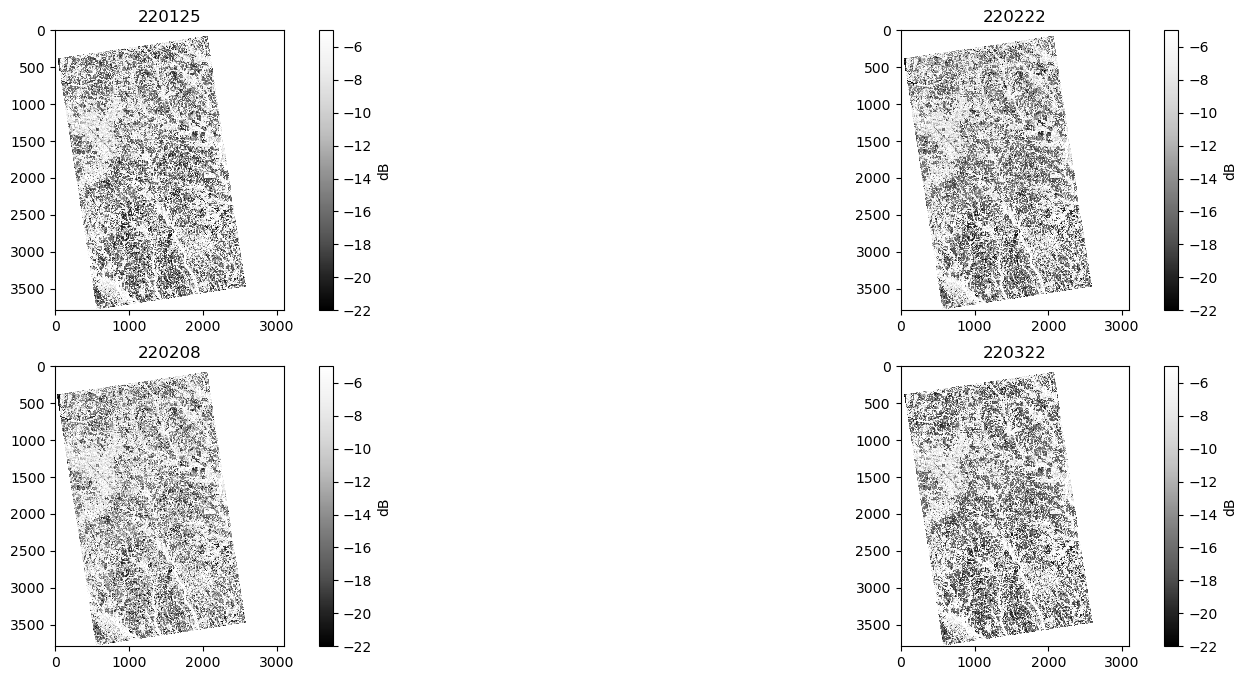

In [22]:
cmp = plt.get_cmap('Greys_r')
plt.rcParams['figure.figsize'] = (20,8)
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.imshow(10*np.log10(a[i,:,:]),vmin=-22,vmax=-5,interpolation='nearest',cmap=cmp)
    plt.colorbar(label = 'dB')
    plt.title(SAR_images[i].split('/')[-1].split('_')[2][-6:]) ## This will change once we rename the files to NISAR format


[back to TOP](#TOP)<br>
[back to TOC](#TOC)

<a id="SEC_3.2"></a>
## 3.2 &emsp; Calculating the CV on the Timeseries Stack

The equation for the Coefficient of Variation (CV) is:

CV = Standard Deviation / Mean

Text(0.5, 1.0, 'Mean Radar-Cross Section (dB)')

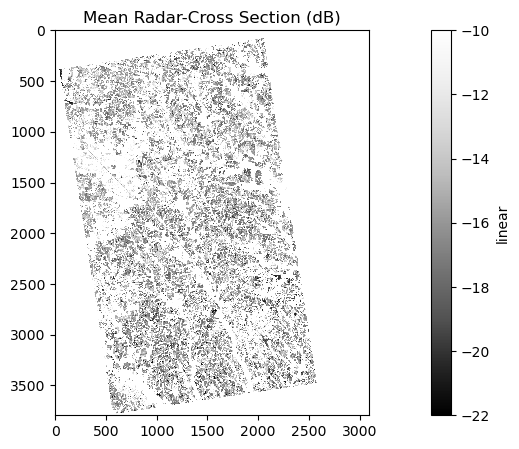

In [23]:
# Calculate the mean for the time stack of images
mean = np.mean(a, axis = 0)


# Calculate the standard deviation for the time stack of images
std = np.std(a, axis = 0)

# Calculate the coefficient of variation for the time stack of images 
CV = (std/mean)*mask


plt.rcParams['figure.figsize'] = (20,5)
plt.imshow(10*np.log10(mean),vmin=-22,vmax=-10,interpolation='nearest',cmap=cmp);
plt.colorbar(fraction=0.046*mean.shape[0]/mean.shape[1],pad=0.04,label='linear');
plt.title('Mean Radar-Cross Section (dB)')

Values in dB
Pixel Standard Deviation: Min = 0.000461, Max = 273.367546, Mean = 0.043
Pixel Coefficient of Variation: Min = 0.024433, Max = 2.812075, Mean = 0.34544


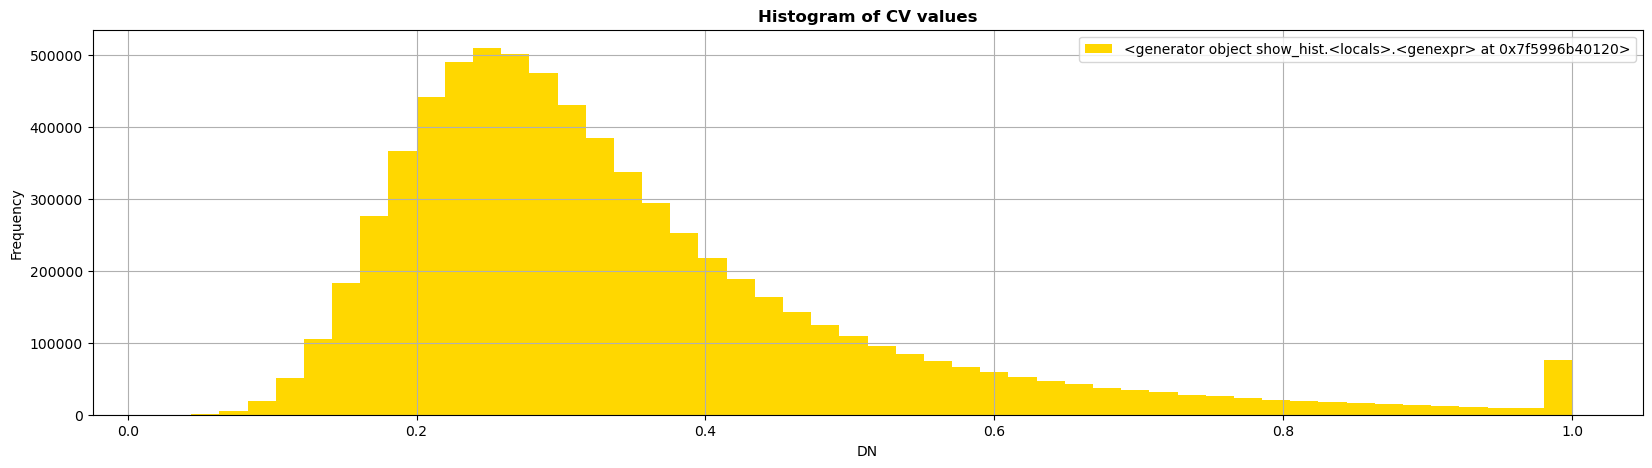

In [24]:
print('Values in dB')
print("Pixel Standard Deviation: Min = %s, Max = %s, Mean = %s" %(round(np.nanmin(std),6),round(np.nanmax(std),6),round(np.nanmean(std),6)))
print("Pixel Coefficient of Variation: Min = %s, Max = %s, Mean = %s" %(round(np.nanmin(CV),6),round(np.nanmax(CV),6),round(np.nanmean(CV),6)))

show_hist(np.clip(CV,0,1),bins=50,title="Histogram of CV values")  # this is the only routine that uses rasterio


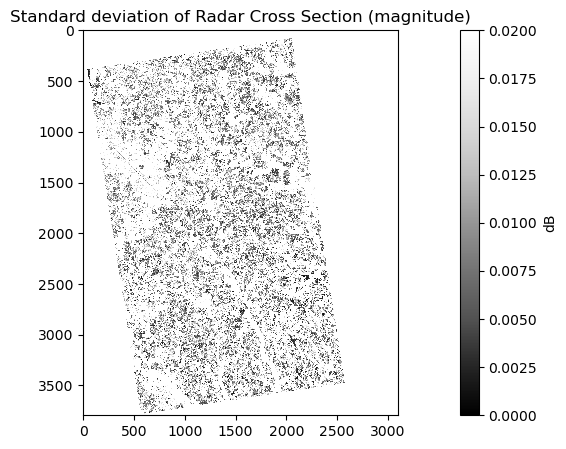

In [25]:
plt.imshow(std,vmin=0,vmax=0.02,interpolation='nearest',cmap=cmp);
plt.colorbar(fraction=0.046*std.shape[0]/std.shape[1],pad=0.04,label='dB');
plt.title('Standard deviation of Radar Cross Section (magnitude)');

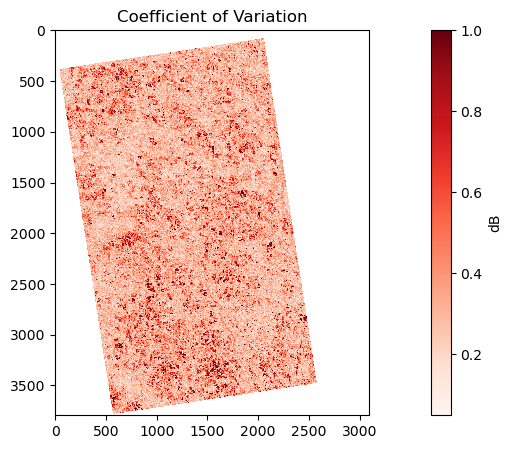

In [26]:
plt.imshow(CV,vmin=0.05,vmax=1,interpolation='nearest',cmap='Reds');
plt.colorbar(fraction=0.046*CV.shape[0]/CV.shape[1],pad=0.04,label='dB');
plt.title('Coefficient of Variation');

[back to TOP](#TOP)<br>
[back to TOC](#TOC)

<a id="SEC_4"></a>
# 4 &emsp; Generation of the Receiver Operating Characteristic
The Receiver Operating Characteristic ([ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)) is a well-known graphical analysis device that can be used for evaluating the choice of thresholds in a binary classification.  It is a plot of the False Positive (a.k.a. False Alarm Rate) versus the True Positive rates in a standard hypothesis test.  Graphical limits of the ROC for the horizontal and vertical axes are between zero and one, indicating ranges of zero probability up to a probability of one.

Curves in the ROC represent a choice of thresholds of the discriminating variable, in this case, the Coefficient of Variation (CV) that has been derived in the previous section.  Using the Crop/Non-crop map derived from the CDL, the CV derived from a SAR time-series, thresholds can be implemented value-by-value to create a locus of points that create a curve in the ROC space.  A diagonal line with a slope of one in the ROC indicates an arbitrary choice.  As the ability of the discriminating metric improves, the loci of points will tend towards the upper left-hand corner (ULC) of the ROC.  The upper left-hand corner of the ROC indicates a False Alarm rate of zero, and a True positive rate of unity.  The threshold that is furthest away from the diagonal line representing arbitrary choice, and closest to the ULC can be considered the optimal choice for the Crop/Non-Crop hypothesis test.

In what follows is a systematic method for generating this locus of points that uses the Coefficient of Variation for the Crop/Non-Crop classifier based on the SAR time-series.  In the absence of a ground-validation component such as the Crop/Non-Crop input from the CDL, the choice of threshold can be determined from previous analysis that has been performed for the optimum CV threshold.  For Sentinel-1 C-band data, this optimum CV threshold is in the range of 0.3 - 0.5.  For L-band data, the optimal threshold of CV value ranges from 0.4 - 0.5.  Using the CDL as an input, a spatial dependence of the CV values has been studied within the US and can be found [here](#SEC_5).


<a id="SEC_4.1"></a>
## 4.1 &emsp; Applying thresholds to determine the ROC
To create the curve 100 different sensitivity points ranging between 0 and 1 in steps of 0.1 were tested. 

<a id="SEC_4.2"></a>
## 4.2 &emsp; Apply the watermask to each tested point

The watermask is applied by subtracting thewatermask from the CV reclassified raster 

        0-0 =     0     Non-crop
        1-111 = -110    Water
        1-0 =     1     Crop
        0-111 = -111    Water
        
A watermask is necessary because the CV values for water is similar to that of an active crop.


<a id="SEC_4.3"></a>
## 4.3 &emsp; Create a binary crop/non-crop classification at each tested threshold

Creating a binary crop/non-crop classification at each tested threshold.

          1 = crop
        -10 = noncrop


<a id="SEC_4.4"></a>
## 4.4 &emsp; Determine false alarm and true positive rates

Finding the correctly and incorrectly classified pixels from each classification.

Subtracted the binary crop/non-crop classification from the correct binary crop/non-crop classification from the CDL.

        0 - -10 = 10       non-crop correctly classified as non-crop
        1 - 1 =   0        crop correctly classified as crop
        0 - 1 =  -1        non-crop incorrectly classified as crop
        1- -10 =  11       crop incorrectly classified as non-crop
        

<a id="SEC_4.5"></a>
## 4.5 &emsp; Calculate sensitivity and specifity

Calculating sensitivity and specificity:

True Positive (TP) = Crop correctly classified as crop

False Positive (FP) = Crop incorrectly classified as non-crop

True Negitive (TN) = Non-crop correctly classified as non-crop

False Negative (FN) = Non-crop incorrectly classified as crop

True Positive Rate (TPR) = Sensitivity

False Positive Rate (FPR) = Specificity

Sensitivity = TP / (TP + TN)

Specificity = TN / (TN + FP)

For use in the generation of a ROC curve (1 - Specificity) is plotted by Sensitivity


<a id="SEC_4.6"></a>
## 4.6 &emsp; Calculate the ROC Curve

An array is set up in order to plot the full ROC curve that includes all of the thresholds and False Alarm/True Positive rates calculated so far.


In [27]:
CV_reclass = np.zeros((100,CV.shape[0],CV.shape[1]))
CV_reclass[:] = np.copy(CV)

CV_water = np.zeros((100,CV.shape[0],CV.shape[1]))

CV_crop_non = np.zeros((100,CV.shape[0],CV.shape[1]))
CV_crop_non = np.copy(CV_water)

CDL_CV = np.zeros((100,CV.shape[0],CV.shape[1]))

denom_sens = np.zeros((100))
sensitivity_y = np.zeros((100))
denom_spec = np.zeros((100))
specificity_x = np.zeros((100))
sub_specificity_x = np.zeros((100))

data55_tmp =[]
fpr_tmp = []
tpr_tmp = []
data100_tmp = []

for i in range(0,100):
    threshold = float(i/100)
    # Reclassify CV array to distingush crop from non-crop
    CV_reclass[i][np.where(CV_reclass[i]>= threshold)] = 1
    CV_reclass[i][np.where(CV_reclass[i]< threshold)] = 0
    
    # Subtract water mask from the CV reclassified raster
    CV_water[i] = np.subtract(CV_reclass[i], watermask)
    
    # Create a binary crop/non-crop classification at each tested threshold.
    CV_crop_non[i] = np.copy(CV_water[i])
    CV_crop_non[i][np.where(CV_crop_non[i]>0)] = 1
    CV_crop_non[i][np.where(CV_crop_non[i]<=0)] = -10
    
    #Subtracted the binary crop/non-crop classification from the correct binary crop/non-crop classification from the CDL.
    CDL_CV[i] = np.subtract(CDL_binary, CV_crop_non[i])
    
    #Calculate sensitivity and specificity
    denom_sens[i] = np.add(np.count_nonzero(CDL_CV[i] == 0), np.count_nonzero(CDL_CV[i] == 11))
    sensitivity_y[i] = np.divide(np.count_nonzero(CDL_CV[i] == 0),denom_sens[i])
    denom_spec[i] = np.add(np.count_nonzero(CDL_CV[i] == 10)- cdl111, np.count_nonzero(CDL_CV[i] == -1))
    specificity_x[i] = np.divide(np.count_nonzero(CDL_CV[i] == 10)- cdl111,denom_spec[i])
    sub_specificity_x[i] = np.subtract(1, specificity_x[i])
  
    # Build array of sub specificity and sensitivity
    data55_tmp.append([sub_specificity_x[i], sensitivity_y[i]])
    fpr_tmp.append([sub_specificity_x[i]])
    tpr_tmp.append([sensitivity_y[i]])
    
    data100_tmp.append([sub_specificity_x[i], sensitivity_y[i]])


<a id="SEC_4.7"></a>
## 4.7 &emsp; Plot the ROC curve

Make a plot of the ROC and indicate locations of various threshold landmarks.


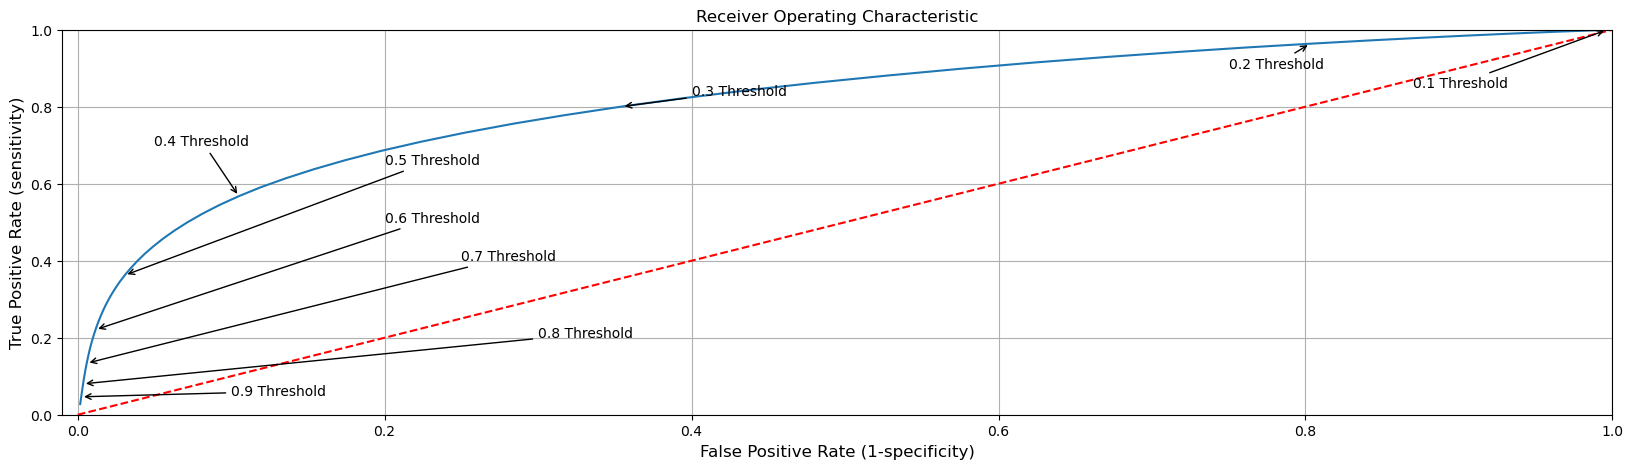

In [28]:
data55 = np.array(data55_tmp)
x, y = data55.T
plt.plot(x, y, '-')
plt.plot([0.0, 1.0], [0.0,1.0], linestyle= "--", color = "red")

#arrows highlighting where each threshold value is

plt.annotate('0.1 Threshold', xy=(sub_specificity_x[10], sensitivity_y[10]),arrowprops=dict(arrowstyle='->'), xytext=(0.87, 0.85)) 
plt.annotate('0.2 Threshold', xy=(sub_specificity_x[20], sensitivity_y[20]),arrowprops=dict(arrowstyle='->'), xytext=(0.75, 0.9)) 
plt.annotate('0.3 Threshold', xy=(sub_specificity_x[30], sensitivity_y[30]),arrowprops=dict(arrowstyle='->'), xytext=(0.4, 0.83)) 
plt.annotate('0.4 Threshold', xy=(sub_specificity_x[40], sensitivity_y[40]),arrowprops=dict(arrowstyle='->'), xytext=(0.05, 0.7)) 
plt.annotate('0.5 Threshold', xy=(sub_specificity_x[50], sensitivity_y[50]),arrowprops=dict(arrowstyle='->'), xytext=(0.2, 0.65)) 
plt.annotate('0.6 Threshold', xy=(sub_specificity_x[60], sensitivity_y[60]),arrowprops=dict(arrowstyle='->'), xytext=(0.2, 0.5)) 
plt.annotate('0.7 Threshold', xy=(sub_specificity_x[70], sensitivity_y[70]),arrowprops=dict(arrowstyle='->'), xytext=(0.25, 0.4)) 
plt.annotate('0.8 Threshold', xy=(sub_specificity_x[80], sensitivity_y[80]),arrowprops=dict(arrowstyle='->'), xytext=(0.3, 0.2)) 
plt.annotate('0.9 Threshold', xy=(sub_specificity_x[90], sensitivity_y[90]),arrowprops=dict(arrowstyle='->'), xytext=(0.1, 0.05)) 

#Setting up plot layout
plt.ylim(0, 1)
plt.xlim(-0.01, 1)
plt.grid()
plt.title('Receiver Operating Characteristic')
plt.ylabel('True Positive Rate (sensitivity)', fontsize=12)
plt.xlabel('False Positive Rate (1-specificity)', fontsize=12)
plt.rcParams['figure.figsize'] = (20,5)

plt.show()

<a id="SEC_5"></a>
<a id="SEC_5.1"></a>
# 5 &emsp; Calculate optimal threshold and other performance metrics

## 5.1 &emsp; Using Youden's Index to Find the Ideal Classification Threshold
Youden's Index is the point on the ROC curve where sensitivity and specificity are maximized, a maximum difference between TPR and FPR (TPR - FPR). The threshold ranges between 0 and 1. A plot is generated to show the point on the curve where the Youden's Index point is on curve.

[back to TOP](#TOP)<br>
[back to TOC](#TOC)<br>


In [29]:
#setting the inputs

#100 different CV thresholds used 
# thresholds = [0.00, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
# fpr = np.array([sub_specificity0_x, sub_specificity01_x, sub_specificity02_x, sub_specificity03_x, sub_specificity04_x, sub_specificity05_x, sub_specificity06_x, sub_specificity07_x, sub_specificity08_x, sub_specificity09_x, sub_specificity1_x, sub_specificity11_x, sub_specificity12_x, sub_specificity13_x, sub_specificity14_x, sub_specificity15_x, sub_specificity16_x, sub_specificity17_x, sub_specificity18_x, sub_specificity19_x, sub_specificity2_x, sub_specificity21_x, sub_specificity22_x, sub_specificity23_x, sub_specificity24_x, sub_specificity25_x, sub_specificity26_x, sub_specificity27_x, sub_specificity28_x, sub_specificity29_x, sub_specificity3_x, sub_specificity31_x, sub_specificity32_x, sub_specificity33_x, sub_specificity34_x, sub_specificity35_x, sub_specificity36_x, sub_specificity37_x, sub_specificity38_x, sub_specificity39_x, sub_specificity4_x, sub_specificity41_x, sub_specificity42_x, sub_specificity43_x, sub_specificity44_x, sub_specificity45_x, sub_specificity46_x, sub_specificity47_x, sub_specificity48_x, sub_specificity49_x, sub_specificity5_x, sub_specificity51_x, sub_specificity52_x, sub_specificity53_x, sub_specificity54_x, sub_specificity55_x, sub_specificity56_x, sub_specificity57_x, sub_specificity58_x, sub_specificity59_x, sub_specificity6_x, sub_specificity61_x, sub_specificity62_x, sub_specificity63_x, sub_specificity64_x, sub_specificity65_x, sub_specificity66_x, sub_specificity67_x, sub_specificity68_x, sub_specificity69_x, sub_specificity7_x, sub_specificity71_x, sub_specificity72_x, sub_specificity73_x, sub_specificity74_x, sub_specificity75_x, sub_specificity76_x, sub_specificity77_x, sub_specificity78_x, sub_specificity79_x, sub_specificity8_x, sub_specificity81_x, sub_specificity82_x, sub_specificity83_x, sub_specificity84_x, sub_specificity85_x, sub_specificity86_x, sub_specificity87_x, sub_specificity88_x, sub_specificity89_x, sub_specificity9_x, sub_specificity91_x, sub_specificity92_x, sub_specificity93_x, sub_specificity94_x, sub_specificity95_x, sub_specificity96_x, sub_specificity97_x, sub_specificity98_x, sub_specificity99_x])
# tpr = np.array([sensitivity0_y, sensitivity01_y, sensitivity02_y, sensitivity03_y, sensitivity04_y, sensitivity05_y, sensitivity06_y, sensitivity07_y, sensitivity08_y, sensitivity09_y, sensitivity1_y, sensitivity11_y, sensitivity12_y, sensitivity13_y, sensitivity14_y, sensitivity15_y, sensitivity16_y, sensitivity17_y, sensitivity18_y, sensitivity19_y, sensitivity2_y, sensitivity21_y, sensitivity22_y, sensitivity23_y, sensitivity24_y, sensitivity25_y, sensitivity26_y, sensitivity27_y, sensitivity28_y, sensitivity29_y, sensitivity3_y, sensitivity31_y, sensitivity32_y, sensitivity33_y, sensitivity34_y, sensitivity35_y, sensitivity36_y, sensitivity37_y, sensitivity38_y, sensitivity39_y, sensitivity4_y, sensitivity41_y, sensitivity42_y, sensitivity43_y, sensitivity44_y, sensitivity45_y, sensitivity46_y, sensitivity47_y, sensitivity48_y, sensitivity49_y, sensitivity5_y, sensitivity51_y, sensitivity52_y, sensitivity53_y, sensitivity54_y, sensitivity55_y, sensitivity56_y, sensitivity57_y, sensitivity58_y, sensitivity59_y, sensitivity6_y, sensitivity61_y, sensitivity62_y, sensitivity63_y, sensitivity64_y, sensitivity65_y, sensitivity66_y, sensitivity67_y, sensitivity68_y, sensitivity69_y, sensitivity7_y, sensitivity71_y, sensitivity72_y, sensitivity73_y, sensitivity74_y, sensitivity75_y, sensitivity76_y, sensitivity77_y, sensitivity78_y, sensitivity79_y, sensitivity8_y, sensitivity81_y, sensitivity82_y, sensitivity83_y, sensitivity84_y, sensitivity85_y, sensitivity86_y, sensitivity87_y, sensitivity88_y, sensitivity89_y, sensitivity9_y, sensitivity91_y, sensitivity92_y, sensitivity93_y, sensitivity94_y, sensitivity95_y, sensitivity96_y, sensitivity97_y, sensitivity98_y, sensitivity99_y])

thresholds= list(np.linspace(0,99,100) /100)
fpr = np.array(fpr_tmp)
tpr = np.array(tpr_tmp)

#finding the threshold value with the greatest difference between TPR and FPR (x and y axes)
def cutoff_youdens_j(fpr,tpr,thresholds):
    j_scores = tpr-fpr
    j_ordered = sorted(zip(j_scores,thresholds))
    return j_ordered[-1][1]

best_thresh = cutoff_youdens_j(fpr,tpr,thresholds)
print ("The best threshold from Youden's Index: ", best_thresh)

The best threshold from Youden's Index:  0.35


In [30]:
#displays Youden's Index calculated point on cure 

best_thresh_index = np.where(thresholds==best_thresh)
fpr_specificity_ideal = fpr[best_thresh_index][0]
tpr_sensitivity_ideal = tpr[best_thresh_index][0]

data100 = np.array(data100_tmp)


<a id="SEC_5.2"></a>
## 5.2 &emsp; Display Youden's Index

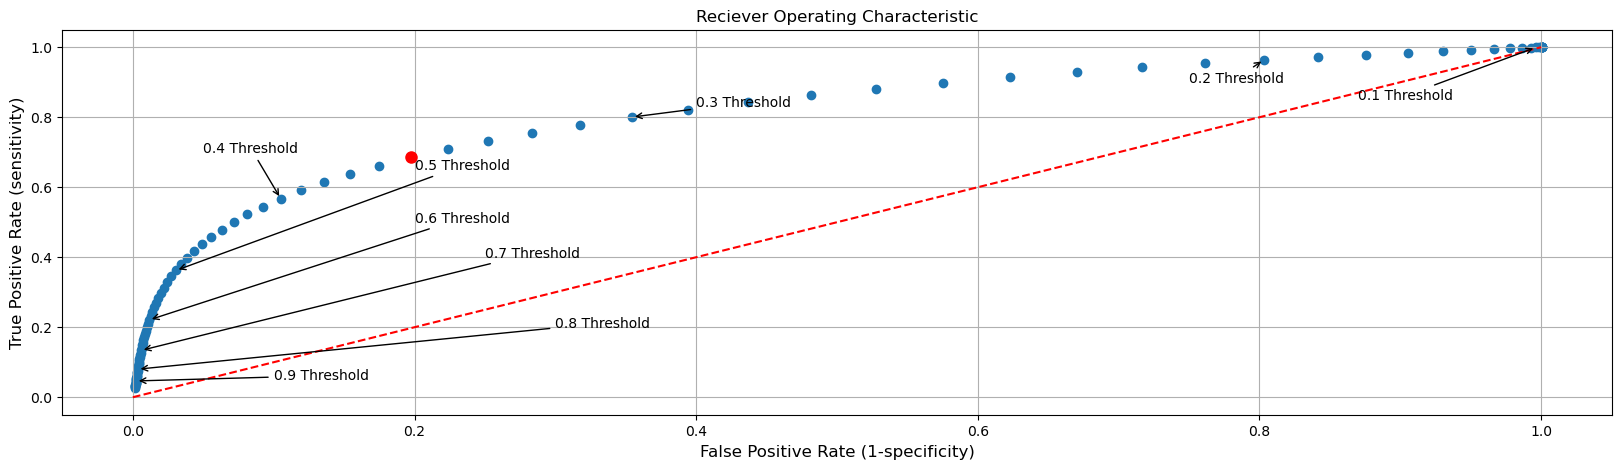

In [31]:
x, y = data100.T
plt.scatter(x, y)
plt.plot([0.0, 1.0], [0.0,1.0], linestyle= "--", color = "red")
plt.plot([fpr_specificity_ideal], [tpr_sensitivity_ideal], marker='o', markersize=8, color="red")

#arrows highlighting where each threshold value is
plt.annotate('0.1 Threshold', xy=(sub_specificity_x[10], sensitivity_y[10]),arrowprops=dict(arrowstyle='->'), xytext=(0.87, 0.85)) 
plt.annotate('0.2 Threshold', xy=(sub_specificity_x[20], sensitivity_y[20]),arrowprops=dict(arrowstyle='->'), xytext=(0.75, 0.9)) 
plt.annotate('0.3 Threshold', xy=(sub_specificity_x[30], sensitivity_y[30]),arrowprops=dict(arrowstyle='->'), xytext=(0.4, 0.83)) 
plt.annotate('0.4 Threshold', xy=(sub_specificity_x[40], sensitivity_y[40]),arrowprops=dict(arrowstyle='->'), xytext=(0.05, 0.7)) 
plt.annotate('0.5 Threshold', xy=(sub_specificity_x[50], sensitivity_y[50]),arrowprops=dict(arrowstyle='->'), xytext=(0.2, 0.65)) 
plt.annotate('0.6 Threshold', xy=(sub_specificity_x[60], sensitivity_y[60]),arrowprops=dict(arrowstyle='->'), xytext=(0.2, 0.5)) 
plt.annotate('0.7 Threshold', xy=(sub_specificity_x[70], sensitivity_y[70]),arrowprops=dict(arrowstyle='->'), xytext=(0.25, 0.4)) 
plt.annotate('0.8 Threshold', xy=(sub_specificity_x[80], sensitivity_y[80]),arrowprops=dict(arrowstyle='->'), xytext=(0.3, 0.2)) 
plt.annotate('0.9 Threshold', xy=(sub_specificity_x[90], sensitivity_y[90]),arrowprops=dict(arrowstyle='->'), xytext=(0.1, 0.05)) 

#Setting plot layout
plt.grid()
plt.title('Reciever Operating Characteristic')
plt.ylabel('True Positive Rate (sensitivity)', fontsize=12)
plt.xlabel('False Positive Rate (1-specificity)', fontsize=12)
plt.rcParams['figure.figsize'] = (10,10)

plt.show()

[back to TOP](#TOP)<br>
[back to TOC](#TOC)<br>


<a id="SEC_5.3"></a>
## 5.3 &emsp; Find the AUC

Area Under the ROC curve (AUC) is a performance measurement (between 0 and 1) describing the discrimination power between the crop and non-crop classes. The higher the AUC value the better the model is at separating the two classes. An AUC value of 0.5 signifies there is no distinguishability between the classes. 

In [32]:
# AUC = (round(sklearn.metrics.auc(fpr, tpr, reorder= 'deprecated'), 2))
AUC = round(sklearn.metrics.auc(fpr, tpr), 2)

print ("Area Under Curve (AUC):", AUC)

Area Under Curve (AUC): 0.81


<a id="SEC_5.4"></a>
## 5.4 &emsp; Getting Accuracy Statictics for the Youden's Index Optimal Threshold

1. Create a crop/non-crop classification based on the Youden's Index optimal threshold
2. Return the J-statistic for the determined threshold (maximum difference value between TPR and FPR ranging between 0 and 1)
3. Get percent crop and non-crop classified correctly and incorrectly
4. Get User's and Producer's accuracy of the classification for both crop and non-crop classes
5. Calculate the Kapppa Coefficient = the measure of the agreement between the SAR imagery derived classification and the CDL
    Kappa = (total pixel x total correct pixel - sum of the products)/(total pixel^2 - sum of products)
    Sum of products = sum of row total x column total 
        Interpreting Kappa Statistic: 
         < 0.20          = Poor agreement 
         0.20 - 0.40     = Fair agreement 
         0.40 - 0.60     = Moderate agreement 
         0.60 - 0.80     = Good agreement 
         0.80 - 1.00     = Very good agreement

In [33]:
#Classify image using the Youden's Index Optimal Threshold
CV_reclass_ideal = np.copy(CV)
CV_reclass_ideal[np.where(CV_reclass_ideal>= best_thresh)] = 1
CV_reclass_ideal[np.where(CV_reclass_ideal< best_thresh)] = 0
CVideal_water = np.subtract(CV_reclass_ideal, watermask)
CVideal_crop_non = np.copy(CVideal_water)
CVideal_crop_non[np.where(CVideal_crop_non>0)] = 1
CVideal_crop_non[np.where(CVideal_crop_non<=0)] = -10
CDL_CVideal = np.subtract(CDL_binary, CVideal_crop_non)

#Determining the J-statistic calculated by finding the maximum difference between the TPR and FPR
j_scores = tpr-fpr
j_ordered = sorted(zip(j_scores,thresholds))
j_statistic = (np.round(j_ordered[-1][0], 2))

#Getting statistics on the accuracy of the CV classification using Youden's Index optimal threshold based on CDL classifications
print ('Statistics of accuracy of using CV to classify crop vs non-crop based on CDL:')
p_crop_correct = np.count_nonzero(CDL_CVideal == 0)/(cdl0)
p_crop_correct1 = (round((p_crop_correct*100), 2))
print ('% correct crop: ',p_crop_correct1)
p_non_correct = (np.count_nonzero(CDL_CVideal == 10)-cdl111)/(cdl0)
p_non_correct1 = (round((p_non_correct)*100, 2))
print ('% correct non-crop: ', p_non_correct1)
p_crop_incorrect = np.count_nonzero(CDL_CVideal == 11)/(cdl0)
p_crop_incorrect1 = (round((p_crop_incorrect)*100, 2))  
print ('% incorrect crop: ', p_crop_incorrect1)
p_non_incorrect = np.count_nonzero(CDL_CVideal == -1)/(cdl0)
p_non_incorrect1 = (round((p_non_incorrect)*100, 2))    
print ('% incorrect non-crop: ', p_non_incorrect1)

#Getting Overall Accuracy statistics of the CV classification using Youden's Index optimal threshold based on CDL classifications
print ('\nStatistics of overall accuracy of using CV to classify crop vs non-crop based on CDL')
p_overall_correct = round((p_crop_correct + p_non_correct)*100, 2)
print ('% overall correct: ', p_overall_correct)
p_overall_incorrect = round((p_crop_incorrect + p_non_incorrect)*100, 2)
print ('% overall incorrect: ', p_overall_incorrect)

#Getting user's and producer's accuracy of the CV classification based on CDL classifications
print ('\nUsers and producers accuracy statistics:')
crop_correct = np.count_nonzero(CDL_CVideal == 0)
non_correct = np.count_nonzero(CDL_CVideal == 10)
crop_incorrect = np.count_nonzero(CDL_CVideal == 11)
non_incorrect = np.count_nonzero(CDL_CVideal == -1)

crop_producers_total = crop_correct + crop_incorrect
non_producers_total = (non_correct - cdl111) + non_incorrect

crop_users_total = crop_correct + non_incorrect
non_users_total = (non_correct - cdl111) + crop_incorrect

crop_p_accuracy = round((crop_correct/crop_producers_total)*100, 2)
print ('% crop producers accuracy: ', crop_p_accuracy)
non_p_accuracy = round(((non_correct - cdl111)/non_producers_total)*100, 2)
print('% non-crop producers accuracy: ', non_p_accuracy)

crop_u_accuracy = round((crop_correct/crop_users_total)*100, 2)
print ('% crop users accuracy: ', crop_u_accuracy)
non_u_accuracy = round(((non_correct - cdl111)/non_users_total)*100, 2)
print ('% non-crop users accuracy: ', non_u_accuracy)

#Calculating Kappa Coefficient
Total_correct = np.count_nonzero(CDL_CVideal == 0) + (np.count_nonzero(CDL_CVideal == 10) - cdl111)

Total_pixel_count = (cdl0)

Sum_of_products_crop_row = np.count_nonzero(CDL_CVideal == 0) + np.count_nonzero(CDL_CVideal == -1)
Sum_of_products_non_row = (np.count_nonzero(CDL_CVideal == 10) - cdl111) + np.count_nonzero(CDL_CVideal == 11)
Sum_of_products_crop_col = np.count_nonzero(CDL_CVideal == 0) + np.count_nonzero(CDL_CVideal == 11)
Sum_of_products_non_col = (np.count_nonzero(CDL_CVideal == 10) - cdl111) + np.count_nonzero(CDL_CVideal == -1)

Sum_of_products = (Sum_of_products_crop_row * Sum_of_products_crop_col) + (Sum_of_products_non_row * Sum_of_products_non_col)

Kappa_coefficient = round((Total_pixel_count * Total_correct - Sum_of_products) / (Total_pixel_count * Total_pixel_count - Sum_of_products), 2)
print ('\nKappa Coefficient: ', Kappa_coefficient)

if Kappa_coefficient <= 0.2:
    print ('Poor agreement')
else:
    if Kappa_coefficient <= 0.4:
        print ('Fair agreement')
    else:
        if Kappa_coefficient <= 0.6:
            print ('Moderate agreement')
        else: 
            if Kappa_coefficient <= 0.8:
                print ('Good agreement')
            else: 
                if Kappa_coefficient > 0.8:
                    print ('Very good agreement')

Statistics of accuracy of using CV to classify crop vs non-crop based on CDL:
% correct crop:  23.01
% correct non-crop:  52.5
% incorrect crop:  10.56
% incorrect non-crop:  12.94

Statistics of overall accuracy of using CV to classify crop vs non-crop based on CDL
% overall correct:  75.51
% overall incorrect:  23.5

Users and producers accuracy statistics:
% crop producers accuracy:  68.54
% non-crop producers accuracy:  80.22
% crop users accuracy:  64.0
% non-crop users accuracy:  83.25

Kappa Coefficient:  0.48
Moderate agreement


[back to TOP](#TOP)<br>
[back to TOC](#TOC)<br>


<a id="SEC_5.5"></a>
## 5.5 &emsp; Export Accuracy Results

Writes the calculated accuracy results to an excel CSV file to the set output directory. 

In [34]:
CV_classification_binary = "NISAR_L3_CropAreaClassification.tif" ##"CV_classification_final.tif"
CV_classification_filename_with_accuracy = "CV_classification_with_accuracy.tif"
Accuracy_results = "NISAR_L3_CropAreaClassification_accuracy_statistics.csv"


In [35]:
#Exporting accuracy statistics as a CSV file

l0 = [best_thresh]
l1 = [p_overall_correct]
l2 = [p_crop_correct1]
l3 = [p_non_correct1]
l4 = [p_crop_incorrect1]
l5 = [p_non_incorrect1]
l6 = [crop_p_accuracy]
l7 = [non_p_accuracy]
l8 = [crop_u_accuracy]
l9 = [non_u_accuracy]
l10 = [Kappa_coefficient]
l11 = [j_statistic]
l12 = [AUC]

df = pd.DataFrame({"Threshold": l0, "Overall Correct": l1, "% crop correct": l2, "% non-crop correct": l3, "% crop incorrect": l4, "% non-crop incorrect": l5, "% Crop Producers Accuracy": l6, "% Non-crop Producers Accuarcy": l7, "% Crop Users Accuracy":l8, "% Non-crop Users Accuracy": l9, "Kappa Coefficient": l10, "J-statistic": l11, "AUC": l12})

df.to_csv(str(aoi_dir / Accuracy_results))

df

,Threshold,Overall Correct,% crop correct,% non-crop correct,% crop incorrect,% non-crop incorrect,% Crop Producers Accuracy,% Non-crop Producers Accuarcy,% Crop Users Accuracy,% Non-crop Users Accuracy,Kappa Coefficient,J-statistic,AUC
0,0.35,75.51,23.01,52.5,10.56,12.94,68.54,80.22,64.0,83.25,0.48,[0.49],0.81


[back to TOP](#TOP)<br>
[back to TOC](#TOC)<br>
[previous section](#SEC_4.4)<br>
[next section](#SEC_4.6)

<a id="SEC_5.6"></a>
## 5.6 &emsp; Export the Classified Image

Writes the array to a geotiff that is classified by the Youden's Index ideal threshold based on CV to the set output directory. 

Crop pixels marked in white (Crop=1, Non-Crop=0)


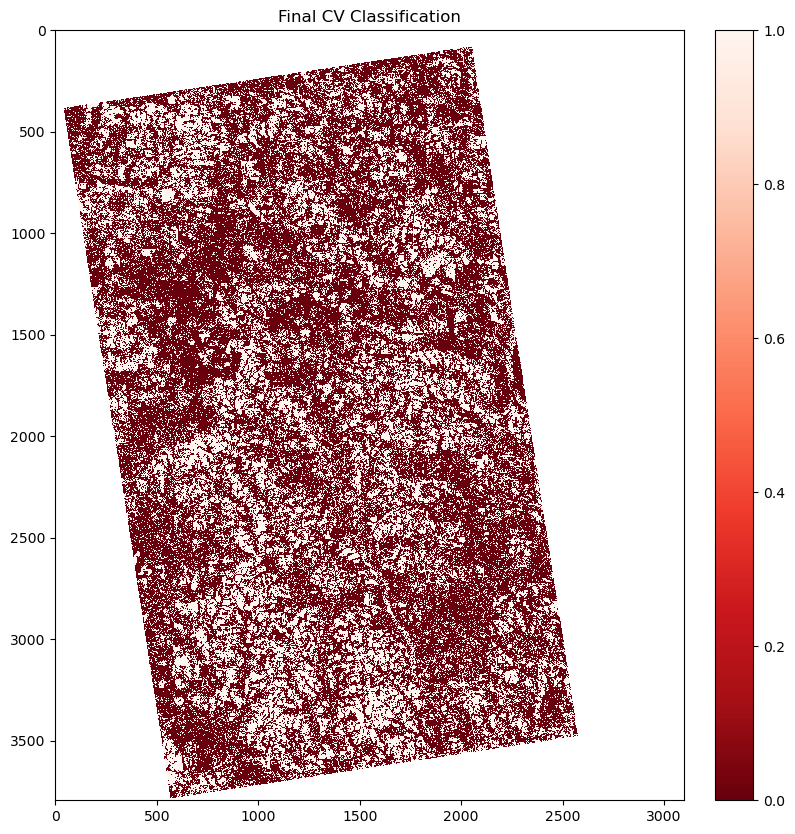

In [36]:
# Define write_geotiff function - writes an array to a geotiff
def write_geotiff_export(image, geotrans, cols, rows, spatial_ref, nodata, outfilename):    
    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(outfilename, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform(geotrans)
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(image)
    outRasterSRS = osr.SpatialReference()
    outband.SetNoDataValue(np.nan)
    outRasterSRS.ImportFromWkt(spatial_ref)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
        
write_geotiff_export(CDL_CVideal, geotransform, cols, rows, spatialref, np.nan, str(aoi_dir / CV_classification_binary))

plt.imshow(CV_reclass_ideal,interpolation='nearest',cmap='Reds_r');
plt.colorbar(fraction=0.046*CV_reclass_ideal.shape[0]/CV_reclass_ideal.shape[1],pad=0.04);
plt.title('Final CV Classification');
print('Crop pixels marked in white (Crop=1, Non-Crop=0)')

[back to TOP](#TOP)<br>
[back to TOC](#TOC)<br>
[previous section](#SEC_4.5)<br>
[next section](#SEC_5)

<a id="SEC_6"></a>
# 6 &emsp; References
The references listed below can be found in the subdirectory "References" listed as part of this Jupyter notebook.


1.	Whelen, T. and P. Siqueira, “A Multi-season Study of L-band UAVSAR Observations for Agricultural Fields in the San Joaquin Valley,” Rem. Sens. Env., 193, 216-224, https://doi.org/10.1016/j.rse.2017.03.014, 2017.

2.	Whelen, T. and P. Siqueira, “Time-series agricultural classification of Sentinel-1 data over North Dakota,” Rem. Sens. Lett., 9(5), 411-420, https://doi.org/10.1080/2150704X.2018.1430393, 2018.

3.	Whelen, T. and P. Siqueira, “Coefficient of variation for use in crop area classification across multiple climates,” Int. J. Appl. Earth. Obs. & Geoinf., 67, 114-122, https://doi.org/10.1016/j.jag.2017.12.014, 2018.

4.	Kraatz, S., N. Torbick, X. Jiao, X. Huang, L.D. Robertson, A. Davidson, H. McNairn, M.H. Cosh, P. Siqueira, “Comparison between Dense L-Band and C-Band Synthetic Aperture Radar (SAR) Time Series for Crop Area Mapping over a NISAR Calibration-Validation Site,” Agronomy. 11(2), https://doi.org/10.3390/agronomy11020273, 2021.

5.	Kraatz, S., S. Rose, M. Cosh, N. Torbick, X. Huang, & P. Siqueira, “Performance evaluation of UAVSAR and simulated NISAR data for crop/noncrop classification over Stoneville, MS.” Earth and Space Sci, 8(1), e2020EA001363. https://doi.org/10.1029/2020EA001363, 2021

6.	Rose, S., S. Kraatz, J. Kellndorfer, M.H. Cosh, N. Torbick, X. Huang, and P. Siqueira, “Evaluating NISAR's cropland mapping algorithm over the conterminous United States using Sentinel-1 data,” Rem. Sens. Env., 260, 112472, https://doi.org/10.1016/j.rse.2021.112472, 2021

[back to TOP](#TOP)<br>
[back to TOC](#TOC)<br>
[previous section](#SEC_4.6)